<a href="https://colab.research.google.com/github/hurtado1820/RedesNeuronales/blob/main/Clasificador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import math
import numpy as np

Se utilizará el dataset Fashion-MNIST de la libreria de Tensorflow. Este dataset es un conjunto de datos de Zalando (tienda de ropa) que cuenta con ejemplos de imágenes en escala de grises de 28x28, cada una asociada a una etiqueta 

In [2]:
#Cargamos nuestro dataset
data, metadata= tfds.load("fashion_mnist", as_supervised=True, with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteCFF3CJ/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteCFF3CJ/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
metadata

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [32]:
#Separamos los datos de entrenamiento y de prueba
train_data = data['train']
test_data = data['test']

In [29]:
#En los metadatos podemos encontrar las categorias del dataset
categories = metadata.features['label'].names
categories

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
#Normalizar los datos haciendo que las entradas sean números entre 0 y 1
#Pasar el valor de cada pixel (0-255 a 0-1)
def normalize (images, labels):
  images = tf.cast(images, tf.float32) 
  images /= 255 
  return images, labels


#Normalizar los datos de entrenamiento y pruebas
train_data = train_data.map(normalize)
test_data = test_data.map(normalize)


#Para un entrenamiento más rápido, almacenar datos en memoria (caché) en lugar de disco
train_data = train_data.cache()
test_data = test_data.cache()

Visualización de la primer imágen cargada del set de datos

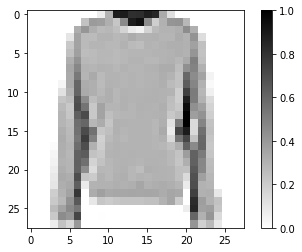

In [7]:
for image, label in train_data.take(1):
  break
image = image.numpy().reshape((28,28))  

#Mostrar imagen
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

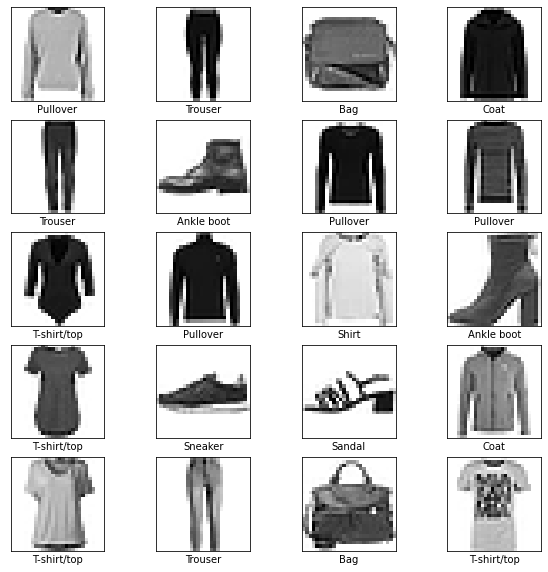

In [8]:
#Imprimir varias imagenes con su corresondiente categoria
plt.figure(figsize=(10,10)) #Tamaño imagen
for index, (image, label) in enumerate(train_data.take(20)):
  image = image.numpy().reshape(28,28)
  plt.subplot(5,4,index+1) #5 filas, 4 columnas
  plt.xticks([]) #Marcas eje x
  plt.yticks([])
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(categories[label]) #Categoria para cada imagen
plt.show()  

#Crear el modelo

In [45]:
#Red de tipo secuencial

modelo = tf.keras.Sequential([
  #Capa de entrada, imagenes de 28x28 en 1 canal (b&w)
  tf.keras.layers.Flatten(input_shape=(28,28,1)),
  #Capas ocultas densas con 50 neuronas cada una, activacion relu
  tf.keras.layers.Dense(50,activation=tf.nn.relu),  
  tf.keras.layers.Dense(50,activation=tf.nn.relu), 
  #Capa de salida con 10 neuronas, softmax para redes clasificacion
  tf.keras.layers.Dense(10,activation=tf.nn.softmax),                                                                   
])

En la función softmax para la capa de salida, aseguramos que la suma de la salida siempre nos da 1.
Al clasificar una imagen le puede asignar valores diferentes en cada categoria, la suma de estos da 1. El que tiene el mayor número es la predicción de la red

In [46]:
#Compilar el modelo

modelo.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [47]:
#Obtener tamaño set de entrenamiento y pruebas
train_size = metadata.splits['train'].num_examples
test_size = metadata.splits['test'].num_examples
print(train_size)
print(test_size)

60000
10000


In [48]:
#Dividimos en pequeños lotes nuestra data
LOT = 32

#Datos de entrenamiento en orden aleatorio para cada iteracion
train_data = train_data.repeat().shuffle(train_size).batch(LOT)
test_data = test_data.batch(LOT)

In [49]:
#Entrenar modelo
historial = modelo.fit(train_data,epochs=5, steps_per_epoch=math.ceil(train_size/LOT))

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 1.8172 - accuracy: 0.7052
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6896 - accuracy: 0.7780
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6349 - accuracy: 0.7919
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5837 - accuracy: 0.8044
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5438 - accuracy: 0.8140


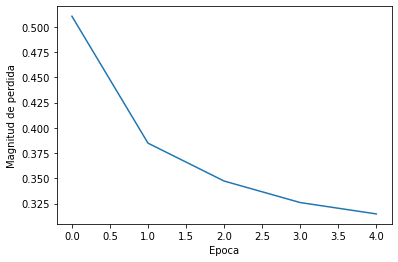

In [14]:
#Funcion de perdida en cada epoca 
plt.xlabel('Epoca')
plt.ylabel('Magnitud de perdida')
plt.plot(historial.history['loss'])

#Probando el modelo

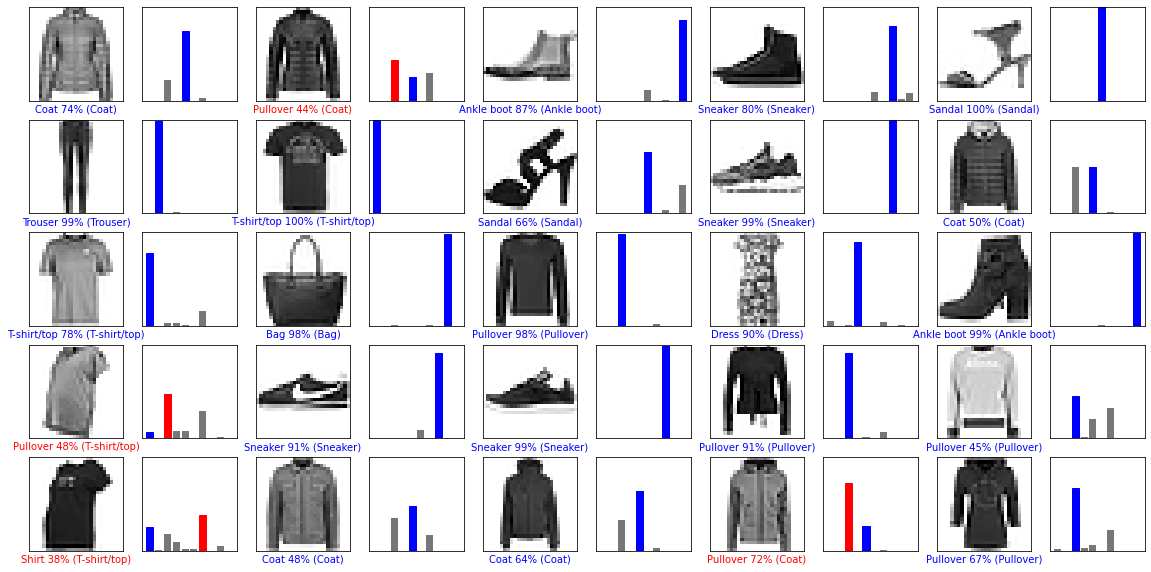

In [54]:
for imagenes_prueba, etiquetas_prueba in test_data.take(1):
  image_test = imagenes_prueba.numpy()
  label_test = etiquetas_prueba.numpy()
  predictions = modelo.predict(imagenes_prueba)

def graph(i,arr_predict, real_labels, images):
  arr_predict, real_label, img = arr_predict[i], real_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])  
  plt.yticks([])

  plt.imshow(img[...,0],cmap=plt.cm.binary)

  label_predict = np.argmax(arr_predict)
  if label_predict == real_label:
    color = 'blue' #Correcta prediccion
  else:
    color = 'red'  #Incorrecta

  plt.xlabel("{} {:2.0f}% ({})".format(categories[label_predict],
                                100*np.max(arr_predict),
                                categories[real_label]),
                                color=color)

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')
  
rows = 5
columns = 5
num_imagenes = rows*columns
plt.figure(figsize=(2*2*columns, 2*rows))
for i in range(num_imagenes):
  plt.subplot(rows, 2*columns, 2*i+1)
  graph(i,predictions, label_test, image_test)
  plt.subplot(rows, 2*columns, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)  